In [1]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal

import gym

from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class ActorStochastic(nn.Module):
    def __init__(self, s_dim, a_dim, action_boundaries, hidden_dim=256, num_hidden_layers=2):
        super(ActorStochastic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))

        self.f = nn.Sequential(*layers)
        self.mean = nn.Linear(hidden_dim, a_dim)
        self.log_std = nn.Linear(hidden_dim, a_dim)

        self.action_boundaries = action_boundaries

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        out = self.f(state)
        mean = self.mean(out)
        log_std = self.log_std(out)

        #out = torch.tanh(out)
        #log_std = torch.tanh(log_std)
        #std = torch.exp(log_std)
        #noise = torch.normal(0, 1, out.shape[0])
        #action = mean + noise * std
        #dist=torch.distributions.Normal(mean, log_std)
        # log_std = torch.clamp(log_std, -20, 2)
        
        log_std = torch.clamp(log_std, -20, 2)
        
        return mean, log_std

    def sampling(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        x_t = dist.rsample() #reparametrization trick implemented by pytorch
        action = torch.tanh(x_t) #Bounds the action
        log_prob = dist.log_prob(x_t) # Log probability(/ies if state in batch)
        log_Jacobian = torch.log(1-action**2+1e-10)#.sum(dim=1, keepdim=True)
        #print(log_Jacobian)
        log_prob = (log_prob-log_Jacobian).sum(dim=1, keepdim=True)
        return action, log_prob


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [6]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=int(1000), batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = ActorStochastic(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)
        self.critic_target = copy.deepcopy(self.critic).to(device)

    def choose_action(self, state, evaluate=False):
        #print(state.shape)
        if evaluate:
            # Choosing action to give to the environnement and not train the model
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                action, log_prob = self.actor.sampling(state)

            return action.cpu().detach().numpy()[0], log_prob
        
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        # To train actor model and critic
        action, log_prob = self.actor.sampling(state)
        
        return action, log_prob
    
    def critic_train(self, states, actions, rewards, next_states, dones):
        
        with torch.no_grad():
            next_actions, next_log_probs = self.choose_action(next_states, evaluate=False)
            q1_next, q2_next = self.critic_target(next_states, next_actions)
            min_q_next = torch.min(q1_next, q2_next)
            target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * next_log_probs)
            
        
        #print(target_q_value.shape)
        q1, q2 = self.critic(states, actions)
        #print(q1.shape, q2.shape)    
        critic_loss = F.mse_loss(q1, target_q_value) + F.mse_loss(q2, target_q_value)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return critic_loss

    
    def actor_train(self, states):
        actions, log_probs = self.choose_action(states, evaluate=False)
        q1_actor, q2_actor = self.critic(states, actions)
        min_q_actor = torch.min(q1_actor, q2_actor)

        # print(actions.shape, log_probs.shape)
        # print(min_q_actor.shape)
        #print((self.alpha * log_probs - min_q_actor).shape)
            
        actor_loss = (self.alpha * log_probs - min_q_actor).mean(dim=0)

        #print(actor_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return actor_loss

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return None, None

        for i in range(self.grad_steps):
            
            states, actions, rewards, next_states, dones = self.sample_batch()
            
            # Critic train
            self.critic.train()
            critic_loss= self.critic_train(states, actions, rewards, next_states, dones)

            # Actor train
            self.actor.train()
            actor_loss = self.actor_train(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_parameters, parameters in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_parameters.data.copy_(self.tau * parameters.data + (1.0 - self.tau) * target_parameters.data)

        return critic_loss.item(), actor_loss.item()

    def add_elements_to_buffer(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample_batch(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        return states, actions, rewards, next_states, dones

## Mountain car continuous

In [10]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hyperparameters
# s_dim = env.observation_space.shape[0]
# a_dim = env.action_space.shape[0]
# hidden_dim_actor = 64
# hidden_dim_critic = 64
# num_layer_actor = 1
# num_layer_critic = 1
# lr_act = 3e-4
# lr_crit = 3e-4
# gamma = 0.99
# tau = 0.05
# alpha = 0.2
# batch_size = 32
# num_episodes = 100
# update_interval = 1
# target_upd_inter = 1
# buffer_capacity = int(1e6)
# grad_step=1

# #print(a_dim)
# # Initialize SAC agent
# agent = SAC(s_dim, a_dim, hidden_dim_actor=hidden_dim_actor, hidden_dim_critic=hidden_dim_critic, 
#             num_layer_actor=num_layer_actor, num_layer_critic=num_layer_critic, lr_act=lr_act, 
#             lr_crit=lr_crit, gamma=gamma, tau=tau, alpha=alpha, batch_size=batch_size, 
#             grad_steps=grad_step, device=device, buffer_capacity=buffer_capacity)

# # Training loop
# episode_rewards = []
# critic_loss=None
# actor_loss=None

# for episode in range(num_episodes):
#     state, _ = env.reset() # shape of (2,)
#     episode_reward = 0
#     for t in range(1000):
#         action, _ = agent.choose_action(state, evaluate=True)
#         next_state, reward, done, _, _ = env.step(action)
#         agent.add_elements_to_buffer(state, action, reward, next_state, done)
#         state = next_state.copy()
#         episode_reward += reward
        
#         if t % update_interval == 0:
#             critic_loss, actor_loss = agent.train(t)

#         if done:
#             break

#     episode_rewards.append(episode_reward)
#     # if critic_loss is not None:
#     #     print("critic loss: ",critic_loss, "actor loss : ", actor_loss)
#     if (episode + 1) % 10 == 0:
#         print(f"Episode {episode + 1}, Reward: {episode_reward}")

# # Plotting
# plt.plot(episode_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('SAC on MountainCarContinuous-v0')
# plt.show()

In [28]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import random
import copy
import matplotlib.pyplot as plt

# Define Linear Layer
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayer, self).__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    
    def forward(self, x):
        return self.linear_layer(x)

# Define Actor
class ActorStochastic(nn.Module):
    def __init__(self, s_dim, a_dim, action_space, hidden_dim=256, num_hidden_layers=2):
        super(ActorStochastic, self).__init__()
        # layers = [LinearLayer(s_dim, hidden_dim)]
        # for _ in range(num_hidden_layers):
        #     layers.append(LinearLayer(hidden_dim, hidden_dim))
        
        # self.f = nn.Sequential(*layers)
        self.f = nn.Sequential(
                                nn.Linear(s_dim, hidden_dim),
                                nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.ReLU()
                               )
        self.mean = nn.Linear(hidden_dim, a_dim)
        self.log_std = nn.Linear(hidden_dim, a_dim)

        self.action_scale = torch.FloatTensor((action_space.high - action_space.low) / 2.0)
        self.action_bias = torch.FloatTensor((action_space.high + action_space.low) / 2.0)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.f(state)
        mean = self.mean(out)
        log_std = self.log_std(out)
        log_std = torch.clamp(log_std, -20, 2)
        return mean, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        x_t = dist.rsample()  # Reparameterization trick
        action = self.action_scale*torch.tanh(x_t)+ self.action_bias
        log_prob = dist.log_prob(x_t)
        log_prob -= torch.log(self.action_scale*(1 - action.pow(2) + 1e-6))
        log_prob = log_prob.sum(1, keepdim=True)
        return action, log_prob

# Define Q Network
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()
        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))
        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.f(x)

# Define Critic
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

# Define Custom Replay Buffer
class ReplayBuffer:
    def __init__(self, s_dim, a_dim, buffer_capacity=1000000):
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.buffer_capacity = buffer_capacity
        self.size = 0
        self.ptr = 0

        self.states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
        self.actions = np.zeros((buffer_capacity, a_dim), dtype=np.float32)
        self.rewards = np.zeros((buffer_capacity, 1), dtype=np.float32)
        self.next_states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
        self.dones = np.zeros((buffer_capacity, 1), dtype=np.float32)

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.buffer_capacity
        if self.size < self.buffer_capacity:
            self.size += 1

    def sample(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        states = torch.FloatTensor(self.states[idxs])
        actions = torch.FloatTensor(self.actions[idxs])
        rewards = torch.FloatTensor(self.rewards[idxs])
        next_states = torch.FloatTensor(self.next_states[idxs])
        dones = torch.FloatTensor(self.dones[idxs])
        return states, actions, rewards, next_states, dones

# Define SAC
class SAC:
    def __init__(self, s_dim, a_dim, action_space, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, buffer_capacity=1000000, batch_size=256, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size

        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau

        self.actor = ActorStochastic(s_dim, a_dim, action_space, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)

        self.critic_target = copy.deepcopy(self.critic).to(device)
        for p in self.critic_target.parameters():
            p.requires_grad = False

        self.replay_buffer = ReplayBuffer(s_dim, a_dim, buffer_capacity)

    def choose_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if evaluate:
            with torch.no_grad():
                action, _ = self.actor.sample(state)
        else:
            action, _ = self.actor.sample(state)
        
        action=action[0]
        return action.cpu().detach().numpy()[0]

    def add_to_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def update_parameters(self, update_interval):
        if self.replay_buffer.size < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)
        
        with torch.no_grad():
            next_actions, next_log_probs = self.actor.sample(next_states)
            q1_next, q2_next = self.critic_target(next_states, next_actions.detach())
            min_q_next = torch.min(q1_next, q2_next) - self.alpha * next_log_probs.detach()
            q_target = rewards + (1 - dones) * self.gamma * min_q_next.detach()

        q1, q2 = self.critic(states, actions)
        critic_loss = F.mse_loss(q1, q_target) + F.mse_loss(q2, q_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions_pred, log_probs = self.actor.sample(states)
        q1_actor, q2_actor = self.critic(states, actions_pred)
        min_q_actor = torch.min(q1_actor, q2_actor)
        actor_loss = (self.alpha * log_probs - min_q_actor).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        return critic_loss.item(), actor_loss.item()


Box(-1.0, 1.0, (1,), float32)
Episode 5, Reward: -30.430215503734292
Episode 10, Reward: -31.14847893081835
Episode 15, Reward: -30.87076457433443
Episode 20, Reward: -30.365544892624044
Episode 25, Reward: -28.97446574458904
Episode 30, Reward: -28.729676660138885
Episode 35, Reward: -31.253258426451712
Episode 40, Reward: -30.671134352454303
Episode 45, Reward: -30.859511661657372
Episode 50, Reward: -30.032167512192615
Episode 55, Reward: -30.310678614453593
Episode 60, Reward: -29.633648307966183
Episode 65, Reward: -30.560295201338725
Episode 70, Reward: -30.510834326302913
Episode 75, Reward: -31.202095001004455
Episode 80, Reward: -30.52092732345806
Episode 85, Reward: -29.642980407489404
Episode 90, Reward: -31.889794271622357
Episode 95, Reward: -29.486354326257754
Episode 100, Reward: -29.261237415458215


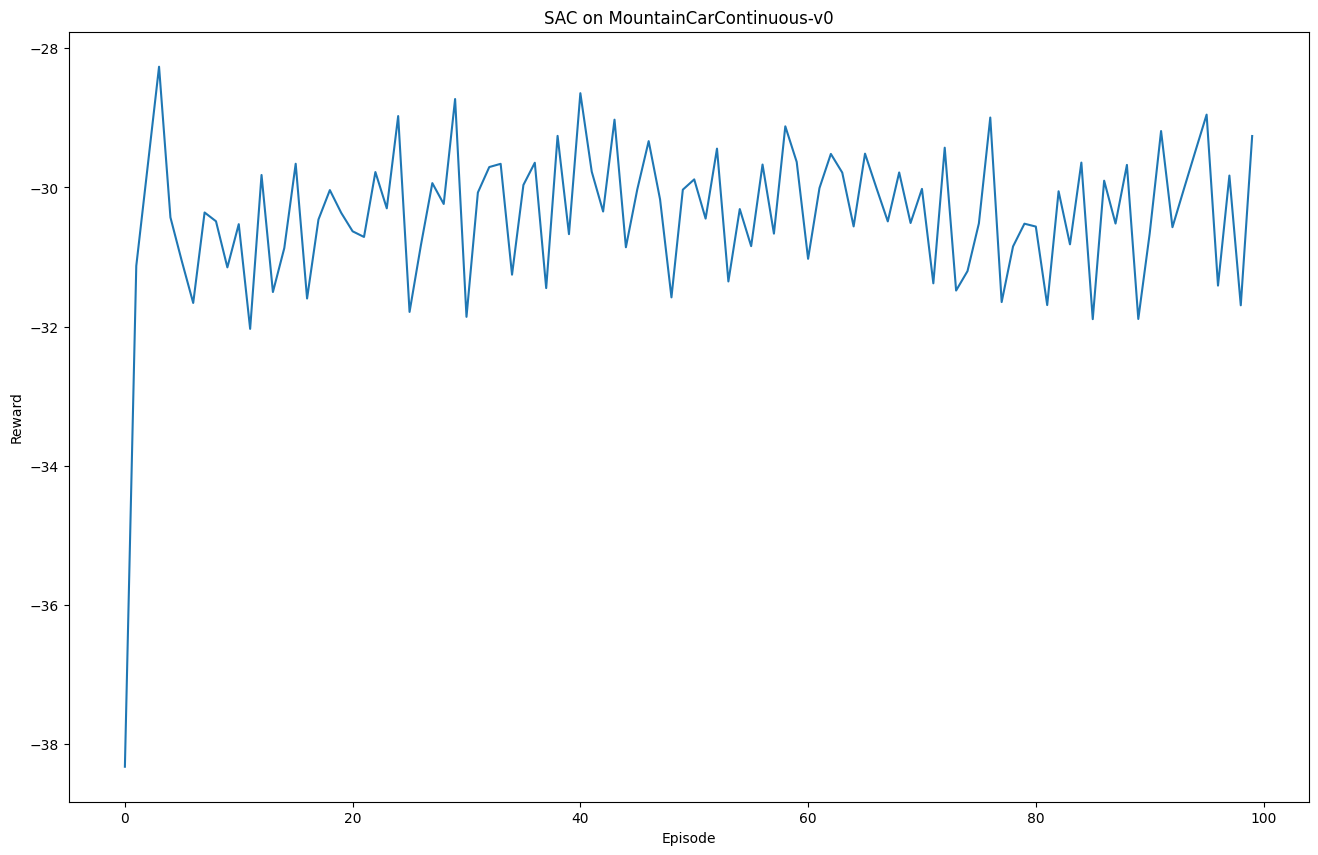

In [36]:
# Create the environment
env = gym.make('MountainCarContinuous-v0')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
action_space = env.action_space
print(action_space)
hidden_dim_actor = 128
hidden_dim_critic = 128
num_layer_actor = 1
num_layer_critic = 1
lr_act = 1e-3
lr_crit = 1e-3
gamma = 0.99
tau = 0.05
alpha = 0.2
batch_size = 64
num_episodes = 100
update_interval = 1
target_upd_inter = 1
buffer_capacity = 10000
num_warmup = 1000

# Initialize SAC agent
agent = SAC(s_dim, a_dim, action_space, hidden_dim_actor, hidden_dim_critic, 
            num_layer_actor, num_layer_critic, lr_act, lr_crit, gamma, tau, 
            alpha, buffer_capacity, batch_size, device)


# Training loop
episode_rewards = []
step_warmup = 0
for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    for t in range(999):
        action = agent.choose_action(state, evaluate=True)
        next_state, reward, done, _, _ = env.step([action])
        agent.add_to_buffer(state, action, reward, next_state, done)
        state = next_state
        episode_reward += reward
        
        if step_warmup>num_warmup:
            if t % update_interval == 0:
                agent.update_parameters(update_interval)
        else:
            step_warmup+=1

        if done:
            break

    episode_rewards.append(episode_reward)
    if (episode + 1) % 5 == 0:
        print(f"Episode {episode + 1}, Reward: {episode_reward}")

# Plotting
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('SAC on MountainCarContinuous-v0')
plt.show()

In [37]:
### Plot the learning progress
def plot_scores(score_history):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    ax.plot(np.arange(1, len(score_history) + 1), score_history, color='green', label='SAC')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

In [53]:
def train_SAC(agent, env, n_games, training_interval=1, update_interval=1, print_num_episodes=10):
    n_games = n_games

    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    training_interval=training_interval
    update_interval = update_interval

    for i in range(n_games):
        state, _ = env.reset()
        done = False
        score = 0
        for _ in range(200):
            action = agent.choose_action(state, evaluate=True)
            next_state, reward, done, _, _ = env.step([action])
            score += reward
            agent.add_to_buffer(state, action, reward, next_state, done)
            state = next_state
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0:
                agent.update_parameters(update_interval)
            if done:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-10:])
        if i%print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            #print(critic_loss, actor_loss, value_loss)
    
    env.close()

    return score_history

## Mountain car continuous

In [25]:
env = gym.make('MountainCarContinuous-v0')

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, buffer_capacity=int(1e5), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=6e-4, lr_crit=6e-4, alpha=0.25, tau=0.005, batch_size=256, device=device)

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=5)
plot_scores(score_history)

C:\Users\guill\AppData\Local\Temp\ipykernel_7324\1723473173.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=self.device)


episode 0 score -33.3 avg score -33.3
episode 5 score -30.5 avg score -31.5
episode 10 score -32.6 avg score -30.9
episode 15 score -30.8 avg score -30.7
episode 20 score -30.2 avg score -30.3
episode 25 score -31.5 avg score -30.7
episode 30 score -30.6 avg score -31.2
episode 35 score -32.9 avg score -31.0
episode 40 score -31.3 avg score -31.0
episode 45 score -32.1 avg score -31.2
episode 50 score -31.6 avg score -31.4
episode 55 score -31.3 avg score -31.2
episode 60 score -31.4 avg score -31.3
episode 65 score -30.6 avg score -31.2
episode 70 score -28.6 avg score -30.7
episode 75 score -31.5 avg score -30.7
episode 80 score -31.3 avg score -30.9
episode 85 score -32.0 avg score -31.1
episode 90 score -31.4 avg score -31.3
episode 95 score -31.1 avg score -31.4
episode 100 score -32.8 avg score -31.5
episode 105 score -31.2 avg score -31.6
episode 110 score -32.2 avg score -31.3
episode 115 score -30.9 avg score -30.7
episode 120 score -29.8 avg score -30.6
episode 125 score -30.

KeyboardInterrupt: 

## Pendulum-v1

In [61]:
env = gym.make('Pendulum-v1')

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space,  buffer_capacity=int(1e6), hidden_dim_actor = 128, hidden_dim_critic=128, 
            num_layer_actor=1, num_layer_critic=1, lr_act=1e-4, lr_crit=1e-4, alpha=0.1, tau=0.05, batch_size=256, device=device)

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=5)
plot_scores(score_history)

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0 score -793.8 avg score -793.8
episode 5 score -1485.6 avg score -1241.1
episode 10 score -1147.5 avg score -1353.2
episode 15 score -1185.3 avg score -1333.2
episode 20 score -1086.1 avg score -1252.9
episode 25 score -1215.0 avg score -1142.0
episode 30 score -1085.4 avg score -1100.9
episode 35 score -960.9 avg score -1173.2
episode 40 score -1001.3 avg score -1137.1
episode 45 score -1046.3 avg score -1052.4
episode 50 score -969.0 avg score -1006.4
episode 55 score -1049.1 avg score -990.8
episode 60 score -1000.4 avg score -1005.4
episode 65 score -885.3 avg score -985.1
episode 70 score -870.8 avg score -968.6
episode 75 score -745.8 avg score -934.8
episode 80 score -633.8 avg score -877.2
episode 85 score -969.1 avg score -864.6
episode 90 score -503.4 avg score -781.1
episode 95 score -967.6 avg score -713.2
episode 100 score -730.7 avg score -722.4
episode 105 score -0.5 avg score -547.4
episode 110 score -1.1 avg score -368.0
episode 115 score -480.2 avg score -329

KeyboardInterrupt: 